# ABU量化系统使用文档 

<center>
        <img src="./image/abu_logo.png" alt="" style="vertical-align:middle;padding:10px 20px;"><font size="6" color="black"><b>第6节 回测结果的度量</b></font>
</center>

-----------------

作者: 阿布

阿布量化版权所有 未经允许 禁止转载

[abu量化系统github地址](https://github.com/bbfamily/abu) (您的star是我的动力！)

[本节ipython notebook](https://github.com/bbfamily/abu/tree/master/abupy_lecture)

首先导入abupy中本节使用的模块：

In [1]:
# 基础库导入

from __future__ import print_function
from __future__ import division

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import os
import sys
# 使用insert 0即只使用github，避免交叉使用了pip安装的abupy，导致的版本不一致问题
sys.path.insert(0, os.path.abspath('../'))
import abupy

# 使用沙盒数据，目的是和书中一样的数据环境
abupy.env.enable_example_env_ipython()

enable example env will only read RomDataBu/df_kl.h5


前面小节中都使用分解流程方式一步一步实现回测，目的是为了更清晰的说明内部操作流程， 编码过程会显的有些复杂臃肿，但实际上在编写完成一个策略后只需要使用一行代码即abu.run_loop_back可以完成回测。

详细代码实现请阅读abu.run_loop_back()函数，下面使用run_loop_back()进行策略示例：

In [2]:
from abupy import AbuFactorBuyBreak
from abupy import AbuFactorAtrNStop
from abupy import AbuFactorPreAtrNStop
from abupy import AbuFactorCloseAtrNStop
# run_loop_back等一些常用且最外层的方法定义在abu中
from abupy import abu, ABuProgress

# 设置初始资金数
read_cash = 1000000
# 设置选股因子，None为不使用选股因子
stock_pickers = None
# 买入因子依然延用向上突破因子
buy_factors = [{'xd': 60, 'class': AbuFactorBuyBreak},
               {'xd': 42, 'class': AbuFactorBuyBreak}]

# 卖出因子继续使用上一节使用的因子
sell_factors = [
    {'stop_loss_n': 1.0, 'stop_win_n': 3.0,
     'class': AbuFactorAtrNStop},
    {'class': AbuFactorPreAtrNStop, 'pre_atr_n': 1.5},
    {'class': AbuFactorCloseAtrNStop, 'close_atr_n': 1.5}
]
# 择时股票池
choice_symbols = ['usNOAH', 'usSFUN', 'usBIDU', 'usAAPL', 'usGOOG',
                  'usTSLA', 'usWUBA', 'usVIPS']
# 使用run_loop_back运行策略
abu_result_tuple, kl_pd_manger = abu.run_loop_back(read_cash,
                                                   buy_factors,
                                                   sell_factors,
                                                   stock_pickers,
                                                   choice_symbols=choice_symbols,
                                                   n_folds=2)
ABuProgress.clear_output()

pid:79853 gen kl_pd complete:100.0%
pid:79854 gen kl_pd complete:100.0%
pid:79854 done!
pid:79853 done!
pid:79855 gen kl_pd complete:100.0%
pid:79855 done!
pid:79856 gen kl_pd complete:100.0%
pid:79856 done!
pid:79857 gen kl_pd complete:100.0%
pid:79857 done!
pid:79858 gen kl_pd complete:100.0%
pid:79858 done!
pid:79859 gen kl_pd complete:100.0%
pid:79859 done!
pid:79860 gen kl_pd complete:100.0%
pid:79860 done!
pid:79861 pick times complete:100.0%
pid:79862 pick times complete:100.0%
pid:79863 pick times complete:100.0%
pid:79864 pick times complete:100.0%
pid:79865 pick times complete:100.0%
pid:79866 pick times complete:100.0%
pid:79868 pick times complete:100.0%
pid:79867 pick times complete:100.0%
pid:79866 done!
pid:79862 done!
pid:79865 done!
pid:79863 done!
pid:79861 done!
pid:79864 done!
pid:79868 done!
pid:79867 done!


如上代码abu.run_loop_back接口只需要买入策略序列，卖出策略序列等必要的用户参数，不再涉及AbuBenchmark，AbuCapital等对象的构建操作行为。

可通过help查看abu.run_loop_back使用帮助, 更多详情请阅读源代码。

In [3]:
help(abu.run_loop_back)

Help on function run_loop_back in module abupy.CoreBu.ABu:

run_loop_back(read_cash, buy_factors, sell_factors, stock_picks=None, choice_symbols=None, n_folds=2, start=None, end=None, commission_dict=None, n_process_kl=16, n_process_pick=8)
    封装执行择时，选股回测。
    
    推荐在使用abu.run_loop_back()函数进行全市场回测前使用abu.run_kl_update()函数首先将数据进行更新，
    在run_kl_update()中它会首选强制使用网络数据进行更新，在更新完毕后，更改数据获取方式为本地缓存，
    使用abu.run_kl_update()的好处是将数据更新与策略回测分离，在运行效率及问题排查上都会带来正面的提升
    
    :param read_cash: 初始化资金额度，eg：1000000
    :param buy_factors: 回测使用的买入因子策略序列，
                    eg：
                        buy_factors = [{'xd': 60, 'class': AbuFactorBuyBreak},
                                       {'xd': 42, 'class': AbuFactorBuyBreak}]
    :param sell_factors: 回测使用的卖出因子序列，
                    eg:
                        sell_factors = [{'stop_loss_n': 0.5, 'stop_win_n': 3.0, 'class': AbuFactorAtrNStop},
                                        {'pre_atr_n': 1.0, 'class': AbuFactorPreAtrNStop},
             

### 1. 度量的基本使用方法

如上help信息所示，abu_result_tuple类型为AbuResultTuple对象，AbuMetricsBase类为abupy对回测结果进行度量的基础类，对于基于股票类型的
市场进行的回测可以直接使用，对于其它市场度量类有自己的专属类，如AbuMetricsFutures为对期货进行度量时使用，后面的章节示例期货回测时会示例使用。

首先通过AbuMetricsBase的参数进行结果度量，如下所示：

* 输出的文字信息打印了胜率、获利期望、亏损期望、策略收益、买入成交比例等信息
* 第一图为策略收益与基准收益对照
* 第二图为策略收益线性拟合曲线
* 第三图为策略收益资金概率密度图

买入后卖出的交易数量:67
买入后尚未卖出的交易数量:3
胜率:55.2239%
平均获利期望:14.1076%
平均亏损期望:-7.8008%
盈亏比:2.2102
策略收益: 48.3078%
基准收益: 15.0841%
策略年化收益: 24.1539%
基准年化收益: 7.5420%
策略买入成交比例:80.0000%
策略资金利用率比例:28.0706%
策略共执行504个交易日


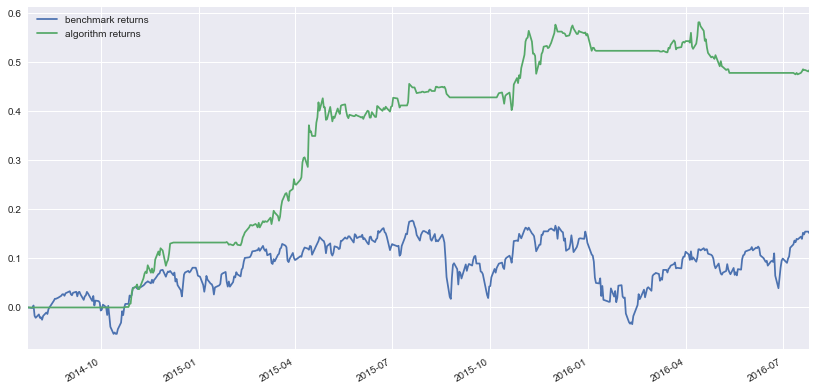

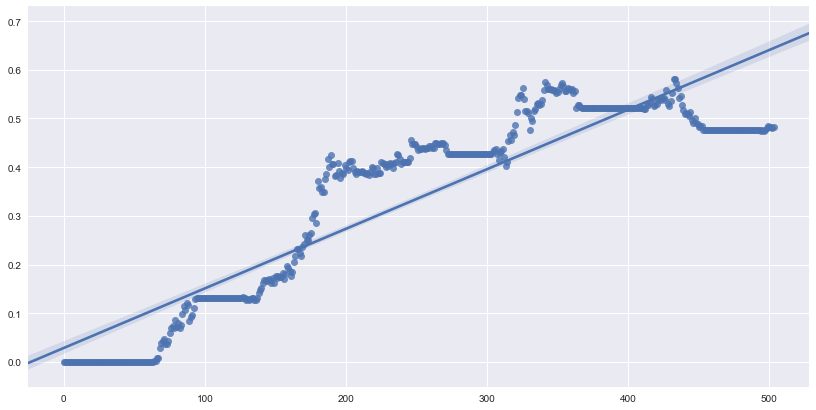

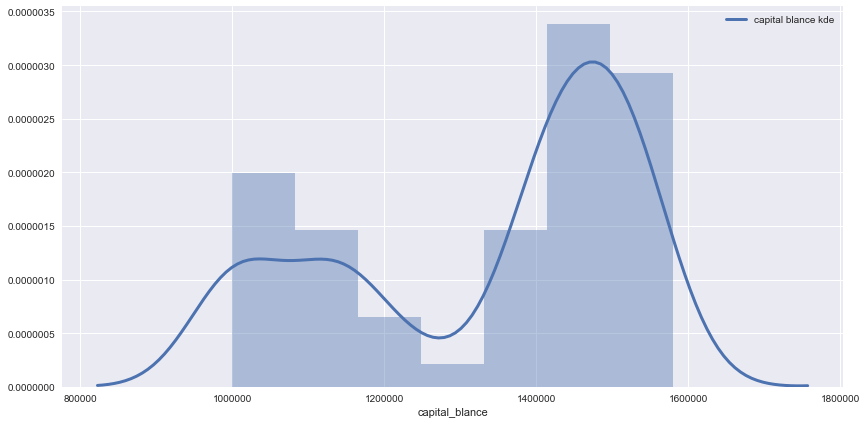

In [4]:
from abupy import AbuMetricsBase
metrics = AbuMetricsBase(*abu_result_tuple)
metrics.fit_metrics()
metrics.plot_returns_cmp()

### 2. 度量的可视化

在AbuMetricsBase执行过程中对回测策略的

- 收益, 年化收益
- 胜率, 盈亏比
- 平均获利期望, 平均亏损期望
- 夏普比率, 信息比率
- 策略波动率, 阿尔法, 贝塔

....................
等度量值进行了计算，详情请阅读AbuMetricsBase源代码，关于这些度量值的基础知识请阅读《量化交易之路》中相关章节。

下面示例一些度量值的可视化：

如下代码通过plot_sharp_volatility_cmp()函数可视化策略与基准之间波动率和夏普比率关系：

alpha阿尔法:0.1899
beta贝塔:0.1594
Information信息比率:0.0423
策略Sharpe夏普比率: 1.8654
基准Sharpe夏普比率: 0.5012
策略波动率Volatility: 0.1090
基准波动率Volatility: 0.1689


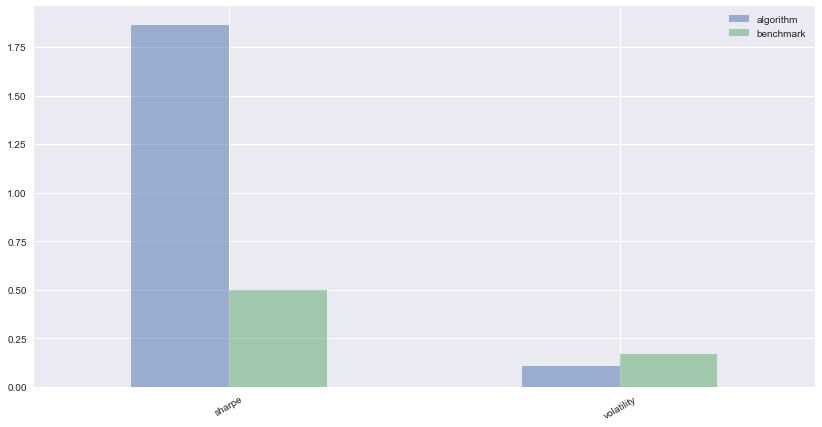

In [5]:
metrics.plot_sharp_volatility_cmp()

如下代码通过plot_effect_mean_day()函数可视化策略买入因子生效间隔天数， 统计买入因子的生效间隔，如图9-3所示。不同的类型的买入因子策略在生效周期上差别很大，组合不同特性的买入因子组成良好的买入策略很重要，但是要注意买入因子的组合不是组合的因子越多，优势越大，所有因子的组合、不光是优势的组合，同时也是劣势的组合。

因子平均生效间隔:16.7105263158


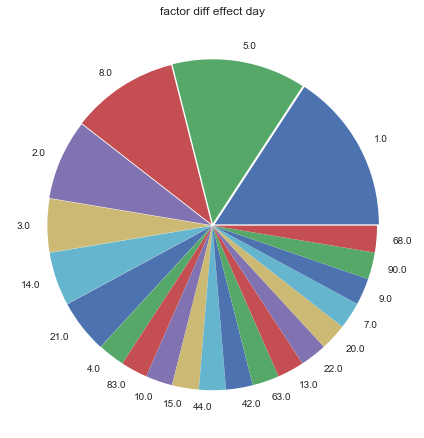

In [6]:
metrics.plot_effect_mean_day()

如下代码通过plot_keep_days()函数可视化策略持股天数：

策略持股天数平均数: 45.429
策略持股天数中位数: 29.000


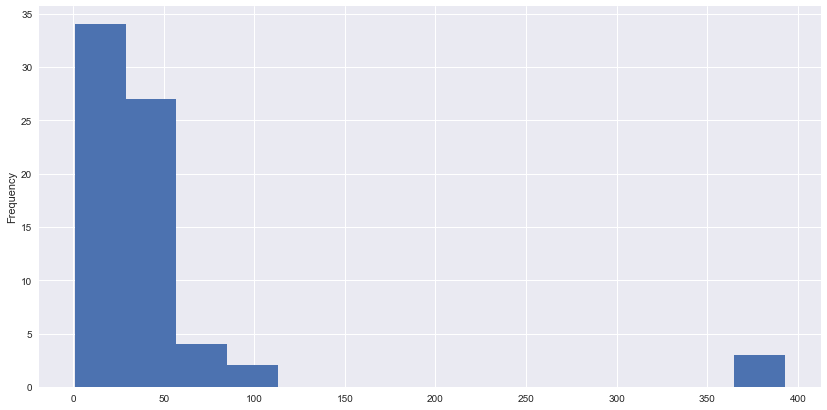

In [7]:
metrics.plot_keep_days()

如下代码通过plot_sell_factors()函数可视化策略卖出因子生效分布情况:

卖出生效因子分布：
AbuFactorAtrNStop:stop_loss=1.0           18
AbuFactorAtrNStop:stop_win=3.0             9
AbuFactorCloseAtrNStop:close_atr_n=1.5    31
AbuFactorPreAtrNStop:pre_atr=1.5           9
dtype: int64


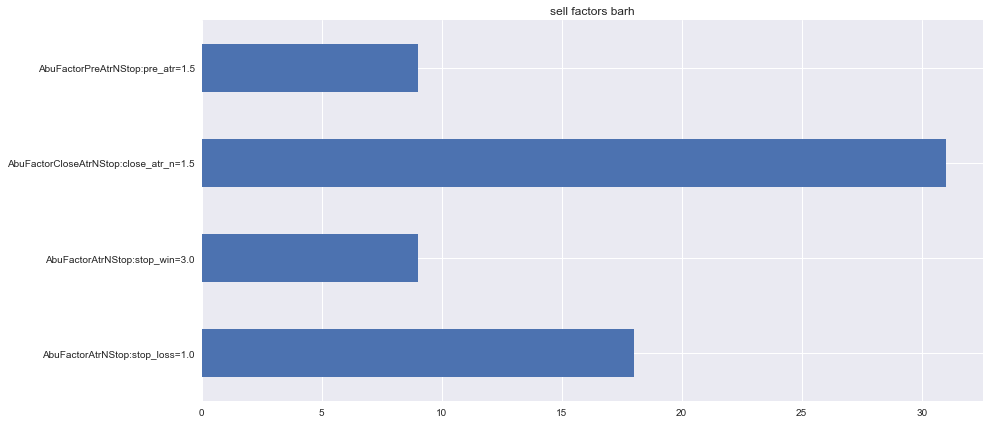

In [8]:
metrics.plot_sell_factors()

plot_max_draw_down()函数中实现了计算最大回撤并可视化:

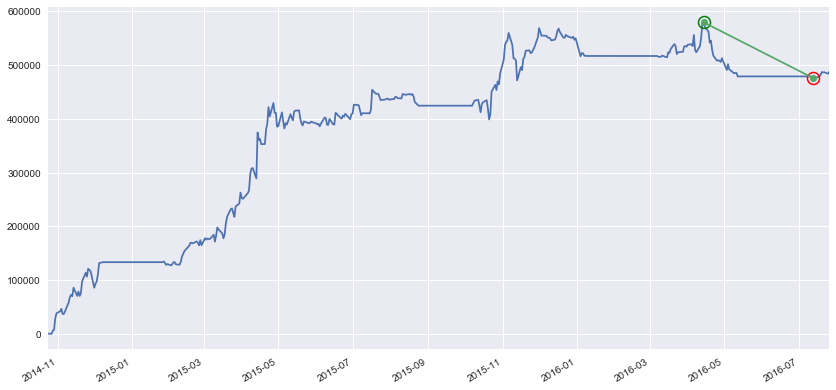

最大回撤: 0.065704
最大回测启始时间:2016-04-14, 结束时间2016-07-13, 共回测103775.665000


In [9]:
metrics.plot_max_draw_down()

### 3. 扩展自定义度量类

用户可以通过继承AbuMetricsBase，扩展度量值，以及添加其它的度量可视化方法。

如下代码示例子类通过实现：

1. 扩展_metrics_extend_stats方法，添加交易手续费变化曲线做为度量值
2. 添加plot_commission度量可视化方法，可视化收益曲线和手续费曲线之前的关系

In [10]:
from abupy import ABuScalerUtil

class MetricsDemo(AbuMetricsBase):
    """扩展自定义度量类示例"""

    def _metrics_extend_stats(self):
        """
            子类可扩展的metrics方法，子类在此方法中可定义自己需要度量的值:
            本demo示例交易手续费和策略收益之间的度量对比
        """
        commission_df = self.capital.commission.commission_df
        commission_df['commission'] = commission_df.commission.astype(float)
        commission_df['cumsum'] = commission_df.commission.cumsum()
        """
            eg:
                type	date	symbol	commission	cumsum
            0	buy	20141024	usAAPL	19.04	19.04
            0	buy	20141024	usAAPL	19.04	38.08
            0	buy	20141029	usNOAH	92.17	130.25
            0	buy	20141029	usBIDU	7.81	138.06
            0	buy	20141029	usBIDU	7.81	145.87
            0	buy	20141029	usVIPS	60.95	206.82
        """
        # 讲date转换为index
        dates_pd = pd.to_datetime(commission_df.date)
        commission = pd.DataFrame(index=dates_pd)
        """
            eg: commission
            2014-10-24	19.04
            2014-10-24	38.08
            2014-10-29	130.25
            2014-10-29	138.06
            2014-10-29	145.87
            2014-10-29	206.82
            2014-11-03	265.82
            2014-11-11	360.73
        """
        commission['cum'] = commission_df['cumsum'].values
        self.commission_cum = commission['cum']
        self.commission_sum = self.commission_cum[-1]

    def plot_commission(self):
        """
            使用计算好的首先费cumsum序列和策略收益cumsum序列进行可视化对比
            可视化收益曲线和手续费曲线之前的关系
        """
        print('回测周期内手续费共: {:.2f}'.format(self.commission_sum))
        # 使用缩放scaler_xy将两条曲线缩放到同一个级别
        x, y = ABuScalerUtil.scaler_xy(self.commission_cum, self.algorithm_cum_returns, type_look='look_max',
                                       mean_how=True)
        x.plot(label='commission')
        y.plot(label='algorithm returns')
        plt.legend(loc=2)
        plt.show()

上面代码的MetricsDemo类即完成了扩展自定义度量类的实现，它可以使用本前面使用的AbuMetricsBase中任何方法，
如metrics.plot_returns_cmp()，metrics.plot_max_draw_down()等等，它独有度量可视化方法plot_commission():

回测周期内手续费共: 4680.93


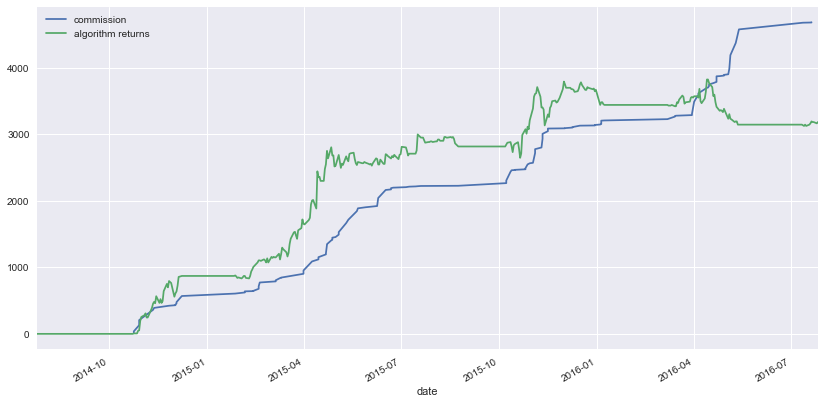

In [11]:
metrics = MetricsDemo(*abu_result_tuple)
metrics.fit_metrics()
metrics.plot_commission()

上面通过plot_commission方法中通过ABuScalerUtil.scaler_xy将两条曲线缩放到一个可视化级别上，可视化的目的是更直观的发现策略中的问题，度量值的意义即是提供发现问题的线索值，如上面两条曲线的走势，当策略收益曲线变缓的时候，手续费曲线应该也要随着变缓慢，如果出现两条曲线背离或者完全不跟随的情况，都代表交易策略有问题。

自定义度量类时也一定要以发现问题为目的，提供线索为手段进行度量类的个性化定制。

备注：关于ABuScalerUtil.scaler_xy等工具的使用在后面的章节会有示例讲解演示

#### abu量化文档目录章节

1. [择时策略的开发](http://www.abuquant.com/lecture/lecture_1.html)
2. [择时策略的优化](http://www.abuquant.com/lecture/lecture_2.html)
3. [滑点策略与交易手续费](http://www.abuquant.com/lecture/lecture_3.html)
4. [多支股票择时回测与仓位管理](http://www.abuquant.com/lecture/lecture_4.html)
5. [选股策略的开发](http://www.abuquant.com/lecture/lecture_5.html)
6. [回测结果的度量](http://www.abuquant.com/lecture/lecture_6.html)
7. [寻找策略最优参数和评分](http://www.abuquant.com/lecture/lecture_7.html)
8. [A股市场的回测](http://www.abuquant.com/lecture/lecture_8.html)
9. [港股市场的回测](http://www.abuquant.com/lecture/lecture_9.html)
10. [比特币，莱特币的回测](http://www.abuquant.com/lecture/lecture_10.html)
11. [期货市场的回测](http://www.abuquant.com/lecture/lecture_11.html)
12. [机器学习与比特币示例](http://www.abuquant.com/lecture/lecture_12.html)
13. [量化技术分析应用](http://www.abuquant.com/lecture/lecture_13.html)
14. [量化相关性分析应用](http://www.abuquant.com/lecture/lecture_14.html)
15. [量化交易和搜索引擎](http://www.abuquant.com/lecture/lecture_15.html)
16. [UMP主裁交易决策](http://www.abuquant.com/lecture/lecture_16.html)
17. [UMP边裁交易决策](http://www.abuquant.com/lecture/lecture_17.html)
18. [自定义裁判决策交易](http://www.abuquant.com/lecture/lecture_18.html)
19. [数据源](http://www.abuquant.com/lecture/lecture_19.html)
20. [A股全市场回测](http://www.abuquant.com/lecture/lecture_20.html)
21. [A股UMP决策](http://www.abuquant.com/lecture/lecture_21.html)
22. [美股全市场回测](http://www.abuquant.com/lecture/lecture_22.html)
23. [美股UMP决策](http://www.abuquant.com/lecture/lecture_23.html)

abu量化系统文档教程持续更新中，请关注公众号中的更新提醒。

#### 《量化交易之路》目录章节及随书代码地址

1. [第二章 量化语言——Python](https://github.com/bbfamily/abu/tree/master/ipython/第二章-量化语言——Python.ipynb)
2. [第三章 量化工具——NumPy](https://github.com/bbfamily/abu/tree/master/ipython/第三章-量化工具——NumPy.ipynb)
3. [第四章 量化工具——pandas](https://github.com/bbfamily/abu/tree/master/ipython/第四章-量化工具——pandas.ipynb)
4. [第五章 量化工具——可视化](https://github.com/bbfamily/abu/tree/master/ipython/第五章-量化工具——可视化.ipynb)
5. [第六章 量化工具——数学：你一生的追求到底能带来多少幸福](https://github.com/bbfamily/abu/tree/master/ipython/第六章-量化工具——数学.ipynb)
6. [第七章 量化系统——入门：三只小猪股票投资的故事](https://github.com/bbfamily/abu/tree/master/ipython/第七章-量化系统——入门.ipynb)
7. [第八章 量化系统——开发](https://github.com/bbfamily/abu/tree/master/ipython/第八章-量化系统——开发.ipynb)
8. [第九章 量化系统——度量与优化](https://github.com/bbfamily/abu/tree/master/ipython/第九章-量化系统——度量与优化.ipynb)
9. [第十章 量化系统——机器学习•猪老三](https://github.com/bbfamily/abu/tree/master/ipython/第十章-量化系统——机器学习•猪老三.ipynb)
10. [第十一章 量化系统——机器学习•ABU](https://github.com/bbfamily/abu/tree/master/ipython/第十一章-量化系统——机器学习•ABU.ipynb)
11. [附录A 量化环境部署](https://github.com/bbfamily/abu/tree/master/ipython/附录A-量化环境部署.ipynb)
12. [附录B 量化相关性分析](https://github.com/bbfamily/abu/tree/master/ipython/附录B-量化相关性分析.ipynb)
13. [附录C 量化统计分析及指标应用](https://github.com/bbfamily/abu/tree/master/ipython/附录C-量化统计分析及指标应用.ipynb)

[更多阿布量化量化技术文章](http://www.abuquant.com/article)

更多关于量化交易相关请阅读[《量化交易之路》](http://www.abuquant.com/books/quantify-trading-road.html)

更多关于量化交易与机器学习相关请阅读[《机器学习之路》](http://www.abuquant.com/books/machine-learning-road.html)

更多关于abu量化系统请关注微信公众号: abu_quant

如有任何问题也可在公众号中联系我的个人微信号。

![](./image/qrcode.jpg)